# Sometimes there is erroneous data that causes the spatiotemporal track splitting algorithm to fail and produce unrealistic tracks. In this case, you might want to explore isolating this data and splitting it another way. 

In [1]:

import trackio as tio
import matplotlib.pyplot as plt

In [2]:
#define the data_path
data_path = 'example0_bad_data'

#define the files
files = ['files/bad_data.csv']

#read the processed Dataset
ds = tio.read(raw_files=files,
              data_path=data_path)

ds


No dataset.db found in c:\code\trackio\notebooks\example0_bad_data. 
Using default units/crs. 
Edit self.meta and then run self.refresh_meta to update.



Type:
    <class 'trackio.Dataset.Dataset'>
Status:
    1 Unprocessed CSV Files
    0 Processed CSV Files
    0 Unsplit Agent Files
    0 Split Agent Files
Static Data Fields:
    []
Dynamic Data Fields:
    ['X', 'Y']
Metadata:
    X: degrees
    Y: degrees
    CRS: EPSG:4326
Data Path:
    c:\code\trackio\notebooks\example0_bad_data

In [3]:
# Split using a basic spatiotemporal threshold
ds = ds.group_points(groupby='MMSI',
                     col_mapper=tio.mappers.columns,                        
                     meta_cols=['MMSI'],
                     prefix='Vessel_',
                     ncores=4)

ds = ds.split_tracks_spatiotemporal(time=3600*12,
                                    distance=0.75)

ds.refresh_meta()

Grouping points: 100%|██████████| 1/1 [00:00<00:00, 667.35it/s]


Refreshing metadata: 100%|██████████| 1/1 [00:00<00:00, 28.56it/s]

New meta/databases saved to c:\code\trackio\notebooks\example0_bad_data


Type:
    <class 'trackio.Dataset.Dataset'>
Status:
    0 Unprocessed CSV Files
    0 Processed CSV Files
    0 Unsplit Agent Files
    1 Split Agent Files
Static Data Fields:
    ['Agent ID', 'MMSI']
Dynamic Data Fields:
    ['Time', 'X', 'Y']
Metadata:
    X: degrees
    Y: degrees
    CRS: EPSG:4326
Data Path:
    c:\code\trackio\notebooks\example0_bad_data

# Let's look for an agent with an abnormal amount of tracks.

In [4]:
agents = ds.agents[ds.agents['ntracks']>10]
agent_ids = agents.index

agents

,MMSI,npoints,ntracks,Xmin,Xmax,Ymin,Ymax,Start Time,End Time,File,geometry
Agent ID,,,,,,,,,,,
Vessel_1,1,57,17,-74.266533,-73.691153,39.427896,40.721166,1970-01-01,1970-01-01 00:00:01,c:\code\trackio\notebooks\example0_bad_data\Ve...,"POLYGON ((-73.69115 39.42790, -73.69115 40.721..."


# If we plot the agent's data, we can clearly see these are three tracks from separate entities that have accidentally use the same unique identifier at the same time

Converting tracks to GeoDataFrame: 100%|██████████| 1/1 [00:00<00:00, 105.15it/s]


<Axes: >

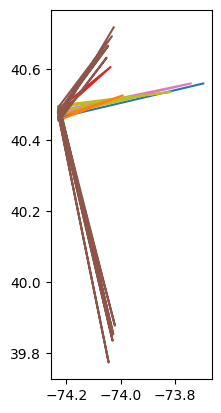

In [5]:
ds.to_gdf().plot(column='Track ID')

Converting tracks to DataFrame: 100%|██████████| 1/1 [00:00<00:00, 117.66it/s]


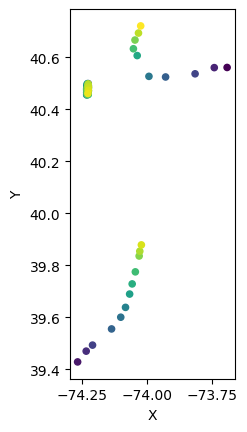

In [6]:
df = ds.to_df(agents=agent_ids)
df.plot.scatter(x='X', y='Y', c='Time').set_aspect('equal')

# Instead, we can first try a modified spatiotemporal approach that can account for this issue.

In [7]:
ds = ds.split_overlapping_tracks_spatiotemporal(agents=agent_ids,
                                                time=3600*12,
                                                distance=0.2)
ds = ds.refresh_meta()

ds.agents

Splitting overlapping tracks using spatiotemporal threshold: 100%|██████████| 1/1 [00:00<00:00, 22.22it/s]
Refreshing metadata: 100%|██████████| 1/1 [00:00<00:00, 74.06it/s]

New meta/databases saved to c:\code\trackio\notebooks\example0_bad_data


,MMSI,npoints,ntracks,Xmin,Xmax,Ymin,Ymax,Start Time,End Time,File,geometry
Agent ID,,,,,,,,,,,
Vessel_1,1,57,3,-74.266533,-73.691153,39.427896,40.721166,1970-01-01,1970-01-01 00:00:01,c:\code\trackio\notebooks\example0_bad_data\Ve...,"POLYGON ((-73.69115 39.42790, -73.69115 40.721..."


# Notice there are only three tracks now.

Converting tracks to GeoDataFrame: 100%|██████████| 1/1 [00:00<00:00, 124.82it/s]


<Axes: >

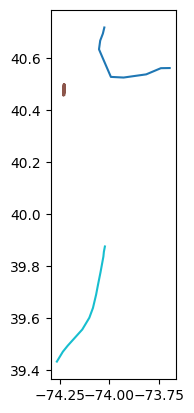

In [8]:
ds.to_gdf().plot(column='Track ID')

# Still, a spatiotemporal splitting might not be able to separate the two closeby tracks. In this case, we can try different clustering algorithms.

# Try K-Means first, since we know the number of clusters.

Using KMeans clustering to split tracks:   0%|          | 0/1 [00:00<?, ?it/s]

Refreshing metadata: 100%|██████████| 1/1 [00:00<00:00, 83.31it/s]


New meta/databases saved to c:\code\trackio\notebooks\example0_bad_data


Converting tracks to GeoDataFrame: 100%|██████████| 1/1 [00:00<00:00, 99.93it/s]


<Axes: >

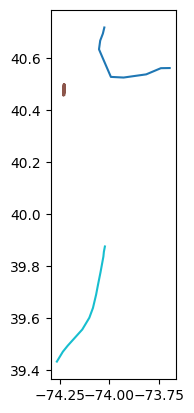

In [9]:
#split tracks using kmeans - simply use X,Y coordinates as features
ds = ds.split_tracks_kmeans(agents=agent_ids,
                            n_clusters=3,
                            feature_cols=['X','Y'])

ds = ds.refresh_meta()

ds.to_gdf().plot(column='Track ID')

# This is a relatively simple example, in some cases this still might not work. In which case, there is a DBSCAN based track splitting algorithm.

Refreshing metadata: 100%|██████████| 1/1 [00:00<00:00, 117.74it/s]


New meta/databases saved to c:\code\trackio\notebooks\example0_bad_data


Converting tracks to GeoDataFrame: 100%|██████████| 1/1 [00:00<00:00, 498.08it/s]


<Axes: >

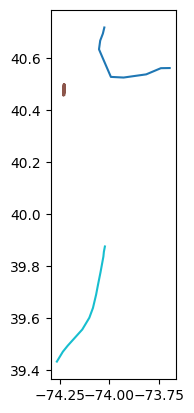

In [10]:
#split tracks using dbscan - the eps and min_samples may take time to get right for your use
ds = ds.split_tracks_dbscan(agents=agent_ids,
                            feature_cols=['X','Y'],
                            eps=1,
                            min_samples=1)

ds = ds.refresh_meta()

ds.to_gdf().plot(column='Track ID')

# In some cases, there might be erroneous data points mixed in with good data. This bad data may have slipped through previous pre-processing and QC checks.


No dataset.db found in c:\code\trackio\notebooks\example0_bad_data1. 
Using default units/crs. 
Edit self.meta and then run self.refresh_meta to update.



Refreshing metadata: 100%|██████████| 1/1 [00:00<00:00, 76.87it/s]


New meta/databases saved to c:\code\trackio\notebooks\example0_bad_data1


Converting tracks to GeoDataFrame: 100%|██████████| 1/1 [00:00<00:00, 117.64it/s]


<Axes: >

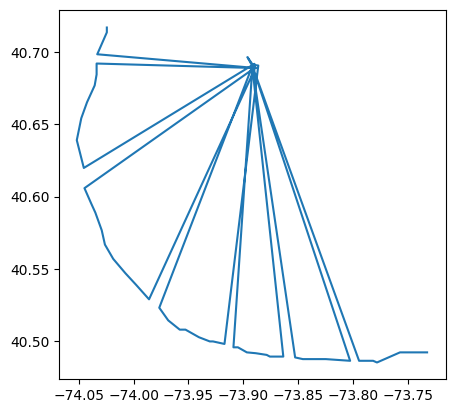

In [11]:
#define the data_path
data_path = 'example0_bad_data1'

#define the files
files = ['files/bad_data1.csv']

#read the processed Dataset
ds = tio.read(raw_files=files,
              data_path=data_path)

#split the points
ds = ds.group_points(groupby='MMSI',
                     col_mapper=tio.mappers.columns,                        
                     meta_cols=['MMSI'],
                     prefix='Vessel_',
                     ncores=4)

#split tracks using basic thresholds
ds = ds.split_tracks_spatiotemporal(time=3600*12,
                                    distance=0.5)

#refresh meta
ds = ds.refresh_meta()

#plot
ds.to_gdf().plot(column='Track ID')


# In this case, where there is obviously erroneous data, you can try "repairing" the spatiotemporal splits.



Refreshing metadata: 100%|██████████| 1/1 [00:00<00:00, 250.02it/s]


New meta/databases saved to c:\code\trackio\notebooks\example0_bad_data1


Converting tracks to GeoDataFrame: 100%|██████████| 1/1 [00:00<00:00, 498.08it/s]


<Axes: >

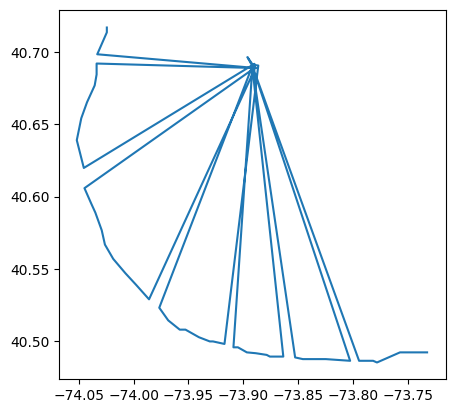

In [12]:
#repair the spatiotemporal splits
ds = ds.repair_tracks_spatiotemporal(time=3600*12,
                                     distance=5)

#refresh meta
ds = ds.refresh_meta()

#plot
ds.to_gdf().plot(column='Track ID')

# FIX THISSS ^^^

# If all else fails, revert to one of the other splitting algorithms. Still if no luck, try to remove this data as part of pre-processig (e.g. clip data overland out of the raw data).

Using DBSCAN clustering to split tracks: 100%|██████████| 1/1 [00:00<00:00, 400.11it/s]


Refreshing metadata: 100%|██████████| 1/1 [00:00<00:00, 80.04it/s]


New meta/databases saved to c:\code\trackio\notebooks\example0_bad_data1


Converting tracks to GeoDataFrame: 100%|██████████| 1/1 [00:00<00:00, 153.82it/s]


<Axes: >

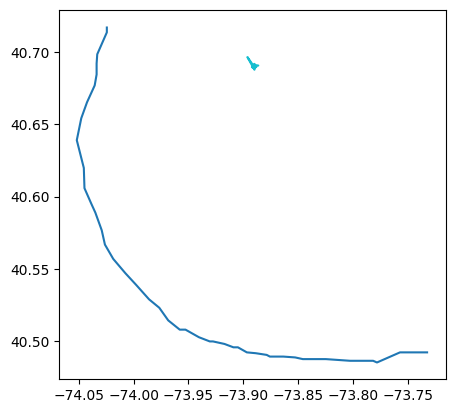

In [13]:
#split using DBSCAN
ds = ds.split_tracks_dbscan(eps=0.5,
                            min_samples=1)

#refresh meta
ds = ds.refresh_meta()

#plot
ds.to_gdf().plot(column='Track ID')

# The last way to split tracks is to split based on dynamic data fields along the track itself. 

# Amongst other use cases, this is useful if you already have a unique identifier for each track and are just trying to get the tracks into the `trackio` framework.

In [14]:
#DO ABOVE

# You can also use this for splitting tracks into sub-tracks based on particular dynamic data fields, such as splitting out portions of tracks within polygons.

# See `11 - Analysis.ipynb` for an example of this.